In [23]:
from kafka import KafkaConsumer

import pandas as pd
from json import dumps
import numpy as np
import pickle
from sklearn.metrics import classification_report,accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

In [24]:
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

for m in consumer:
    print(m.value)
    break

b'"\\u00ef\\u00bb\\u00bftimestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack\\n"'


In [25]:
Static_dataset= pd.read_csv("Static_dataset.csv")
Static_dataset['longest_word'] = Static_dataset['longest_word'].replace(r'(([a-z]+)|([A-Z]+))',2, regex=True)
Static_dataset['longest_word'].fillna(2,inplace=True)
Static_dataset['longest_word']=Static_dataset['longest_word'] .astype('int') 
Static_dataset['sld'] = Static_dataset['sld'].replace(r'(([a-z]+)|([A-Z]+|(0-1)))',192, regex=True)
Static_dataset['sld']=Static_dataset['sld'] .astype('int') 
Static_dataset.drop('timestamp', inplace=True, axis=1)

In [26]:
Static_dataset

,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack
0,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
1,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,1
2,26,9,0,10,10,2.742338,6,6,7,3.500000,2,192,13,1,0
3,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
4,15,9,0,11,0,2.929439,4,3,5,4.333333,2,192,15,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268069,18,3,0,16,0,2.338623,2,3,10,5.333333,2,192,14,1,0
268070,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,0
268071,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,1
268072,16,0,0,14,0,3.249687,2,2,13,7.500000,2,192,14,0,0


In [27]:
Static_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268074 entries, 0 to 268073
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   FQDN_count        268074 non-null  int64  
 1   subdomain_length  268074 non-null  int64  
 2   upper             268074 non-null  int64  
 3   lower             268074 non-null  int64  
 4   numeric           268074 non-null  int64  
 5   entropy           268074 non-null  float64
 6   special           268074 non-null  int64  
 7   labels            268074 non-null  int64  
 8   labels_max        268074 non-null  int64  
 9   labels_average    268074 non-null  float64
 10  longest_word      268074 non-null  int32  
 11  sld               268074 non-null  int32  
 12  len               268074 non-null  int64  
 13  subdomain         268074 non-null  int64  
 14  Target Attack     268074 non-null  int64  
dtypes: float64(2), int32(2), int64(11)
memory usage: 28.6 MB


In [28]:
def get_1000_record(itr):
    list_of_1000_rec=[]
    i=0
    for j in consumer:
        
        if i <1000:
            
            list_of_1000_rec.append(j.value)
            i=i+1
        else:
            
            break
    print(f"Window {itr}")
   
    
    return list_of_1000_rec        
        

In [29]:
column_names =["timestamp","FQDN_count","subdomain_length","upper","lower","numeric","entropy","special","labels","labels_max","labels_average","longest_word","sld","len","subdomain","Target Attack"]
def data_preparation( data):
    df=pd.DataFrame()
    list_of_row=[]
    for i in data:
        row_string=eval(i.decode("UTF-8"))
        row_string = row_string.strip()
        row= row_string.split(",")
        list_of_row.append(row)
    df=pd.DataFrame(list_of_row)
    df.columns=column_names
    return df
    

In [30]:
def data_cleaning(data):
    data['longest_word'] = data['longest_word'].replace(r'(([a-z]+)|([A-Z]+)|'')',2, regex=True)
    data['longest_word'].fillna(2,inplace=True)
    data['sld'] = data['sld'].replace(r'(([a-z]+)|([A-Z]+|(0-1)))',192, regex=True)
    data['sld']=data['sld'] .astype('int') 
    data.drop('timestamp', inplace=True, axis=1)
    return data.astype('float')
    

In [31]:
static_model = Dynamic_model= pickle.load(open('Staitic_model.pkl', 'rb'))

In [32]:
from fast_ml.model_development import train_valid_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import AdaBoostClassifier

In [33]:
def retraining(data):
    X=np.array(data.iloc[:,:-1])
    Y=np.array(data['Target Attack'])
    X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(data, target = 'Target Attack', 
                                                                            train_size=0.6, valid_size=0.2, test_size=0.2)
    anova_filter = SelectKBest(f_classif, k=5)
    clf = AdaBoostClassifier(n_estimators=500, random_state=0,learning_rate=1.0)
    anova_adaboost = make_pipeline(anova_filter, clf)
    anova_adaboost.fit(X_train, y_train)
    

    
    return anova_adaboost

In [34]:
Static_dataset

,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack
0,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
1,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,1
2,26,9,0,10,10,2.742338,6,6,7,3.500000,2,192,13,1,0
3,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
4,15,9,0,11,0,2.929439,4,3,5,4.333333,2,192,15,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268069,18,3,0,16,0,2.338623,2,3,10,5.333333,2,192,14,1,0
268070,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,0
268071,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,1
268072,16,0,0,14,0,3.249687,2,2,13,7.500000,2,192,14,0,0


In [35]:
static_model

Pipeline(steps=[('selectkbest', SelectKBest(k=5)),
                ('adaboostclassifier',
                 AdaBoostClassifier(n_estimators=500, random_state=0))])

In [36]:
list_of_ACC_Dynmaic_model=[]
list_of_ACC_static_model=[]
for itr in range(267):
    
    get_rec_dataset = get_1000_record(itr+1)
    pre_dataset =  data_preparation(get_rec_dataset)
    cleaned_dataset =  data_cleaning(pre_dataset)
    Static_dataset=Static_dataset.append(cleaned_dataset)
    X =cleaned_dataset.drop(labels = ["Target Attack"], axis=1) 
    y=cleaned_dataset["Target Attack"]
    cleaned_dataset.append(Static_dataset)
    Dy_pred=Dynamic_model.predict(X)
    D_acc=accuracy_score(y,Dy_pred)
    print(f"ACC of Dynamic Model without retrain = {D_acc*100}%")
    if D_acc < 0.81 :

        print(" The model will be trained on the new data")
        Dynamic_model=retraining(cleaned_dataset)
        Dy_pred=Dynamic_model.predict(X)
        D_acc=accuracy_score(y,Dy_pred)
        print(f"ACC of Dynamic Model after retrain = {D_acc*100}%")
    Sy_pred=static_model.predict(X)
    S_acc=accuracy_score(y,Sy_pred)
    print(f"ACC of Static Model = {S_acc*100}%")
    list_of_ACC_Dynmaic_model.append(D_acc)
    list_of_ACC_static_model.append(S_acc)
    print(f"{'*'*20}")
   

Window 1
ACC of Dynamic Model without retrain = 81.2%
ACC of Static Model = 81.2%
********************
Window 2
ACC of Dynamic Model without retrain = 81.5%
ACC of Static Model = 81.5%
********************
Window 3
ACC of Dynamic Model without retrain = 79.60000000000001%
 The model will be trained on the new data
ACC of Dynamic Model after retrain = 79.3%
ACC of Static Model = 79.60000000000001%
********************
Window 4
ACC of Dynamic Model without retrain = 81.3%
ACC of Static Model = 81.39999999999999%
********************
Window 5
ACC of Dynamic Model without retrain = 79.5%
 The model will be trained on the new data
ACC of Dynamic Model after retrain = 80.10000000000001%
ACC of Static Model = 80.60000000000001%
********************
Window 6
ACC of Dynamic Model without retrain = 80.4%
 The model will be trained on the new data
ACC of Dynamic Model after retrain = 80.9%
ACC of Static Model = 81.10000000000001%
********************
Window 7
ACC of Dynamic Model without retrain 

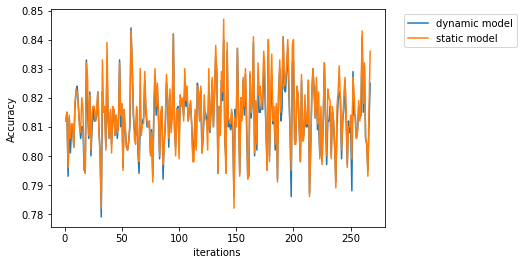

In [37]:
import matplotlib.pyplot as plt
plt.plot(range(1, 268), list_of_ACC_Dynmaic_model, label=f'dynamic model')
plt.plot(range(1, 268),list_of_ACC_static_model, label=f'static model')
plt.xlabel('iterations ')
#plt.xticks(range(1, 251))
plt.ylabel("Accuracy")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")